# Initialization through BNSE for SM kernel

Comparison between initializing sm kernel with different heuristics

* Random (See Andrew Wilson PHD thesis)
* Lomb Scargle
* BNSE

In [1]:
# import library if it is not installed
import sys
sys.path.insert(0, '../')

import mogptk
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.signal import detrend

%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
def get_param_across(model, name='mixture_means'):
    """
    Get all the name parameters across all components
    """
    params = [model.get_params()[q][name] for q in range(model.Q)]
    
    return np.array(params)

In [4]:
def plot_psd(model):
    """
    Plot power spectral density of 
    single output GP-SM
    """
    means = get_param_across(model, 'mixture_means').reshape(-1)
    weights = get_param_across(model, 'mixture_weights').reshape(-1)
    scales = get_param_across(model, 'mixture_scales').reshape(-1)
    
    # calculate bounds
    x_low = norm.ppf(0.001, loc=means, scale=scales).min()
    x_high = norm.ppf(0.99, loc=means, scale=scales).max()
    
    x = np.linspace(x_low, x_high + 1, 1000)
    psd = np.zeros_like(x)
    
    for q in range(model.Q):
        single_psd = weights[q] * norm.pdf(x, loc=means[q], scale=scales[q])
        plt.plot(x, single_psd, '--', lw=1.2, c=sns.color_palette()[3], zorder=2)
        plt.axvline(means[q], ymin=0.001, ymax=0.1, lw=2, color='grey')
        psd = psd + single_psd
        
    # symmetrize PSD
    if psd[x<0].size != 0:
        psd = psd + np.r_[psd[x<0][::-1], np.zeros((x>=0).sum())]
        
    plt.plot(x, psd, lw=2.5, c='r', alpha=0.7, zorder=1)
    plt.xlim(0, x[-1] + 0.1)
    # plt.yscale('log')
    plt.xlabel(r'$\omega$')
    plt.ylabel('PSD')

In [5]:
def experiment(x_train, y_train, x_test, y_test, true_means, Q=3, n_trials=100):
    """
    Experiment with the 3 initializations for GP-SM
    
    The GP is fitted using the data and compared with the real
    parameters. This is done 'n_trial' times for each initialization 
    method.
    """
    # total error
    mae_param = np.zeros((3, n_trials))
    mae_pred = np.zeros((3, n_trials))
    
    x_test = [x_test.reshape(-1, 1)]
    
    # create and train model
    data = mogptk.Data(x_train, y_train)
    
    init_methods = ['random', 'LS', 'BNSE']
    
    for i, method in enumerate(init_methods):
        for n in range(n_trials):
            # pick random seed
            seed = np.random.randint(1, int(1e8))
            np.random.seed(seed)
            
            model = mogptk.SM([data], Q=Q)
            model.init_params(method)
            model.train(maxiter=5000)
            
            # param error
            means_pred = get_param_across(model, 'mixture_means').reshape(-1)
            mae_param[i, n] = np.abs(true_means - means_pred).sum()
            
            # pred error
            y_pred, var_pred = model.predict(x_test)
            mae_pred[i, n] = np.abs(y_test - y_pred[0]).mean()
            
    return mae_param, mae_pred

Create data for the experiment

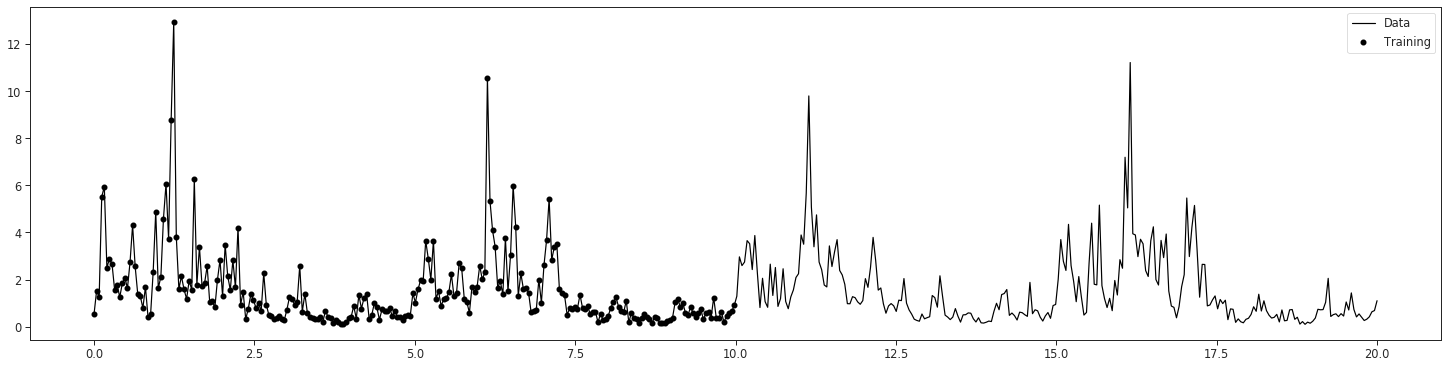

In [6]:
# target freq to estimate
target_freqs = np.array([0.2, 1, 2])
target_amps = [1, 0.5, 0.5]

n_points = 500

t = np.linspace(0, 20, n_points)
y = np.zeros(n_points)

for i in range(3):
    y += target_amps[i] * np.sin(2 * np.pi * target_freqs[i] * t)
    
y_n = y + np.random.normal(scale=0.4, size=n_points)
y_n = np.exp(y_n)
y_n += -y_n.min() + 1e-1

# data class
data = mogptk.Data(t.reshape(-1, 1), y_n)
data.remove_range(start=10.0, end=None)

data.plot()

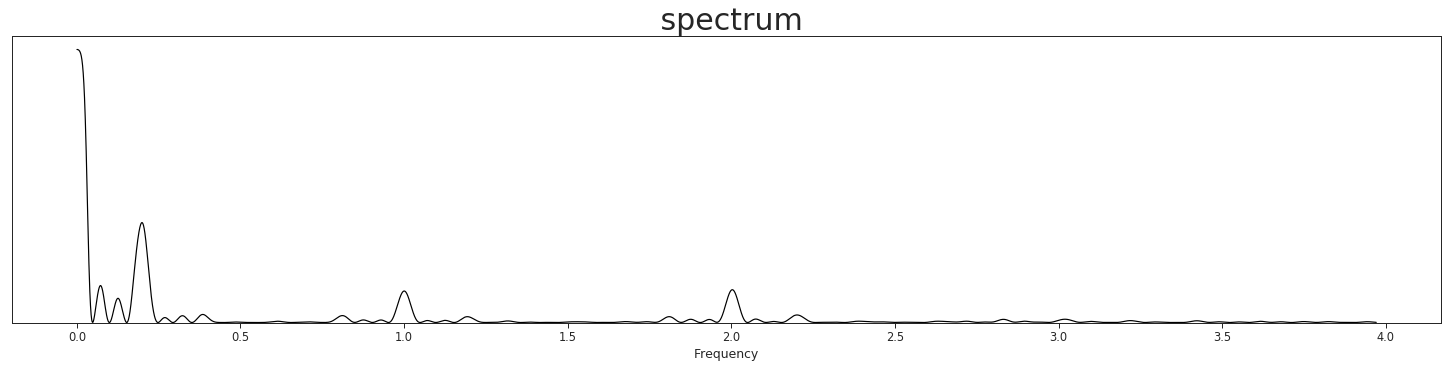

In [7]:
data.plot_spectrum()

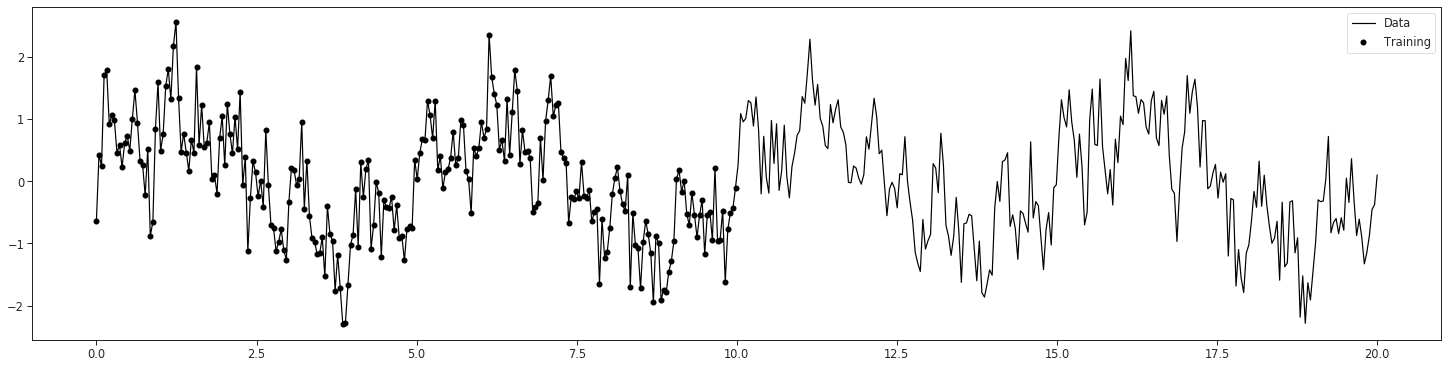

In [8]:
data.transform(mogptk.TransformLog)
data.plot()

Mixture means [[0.78425516]
 [1.05915059]
 [0.915981  ]]
Mixture weights [0.3175461  2.30193815 1.16701475]


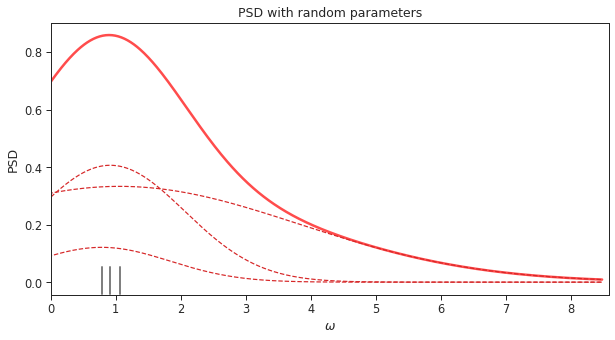

In [9]:
# create model
model = mogptk.SM([data], Q=3)

print('Mixture means', get_param_across(model))
print('Mixture weights', get_param_across(model, 'mixture_weights'))

plot_psd(model)
plt.title('PSD with random parameters');

Mixture means [0.199101  2.0012395 0.9977505]
Mixture scales [0.03739194 0.03671753 0.03682904]
Mixture weights [1.97036846 0.52467932 0.50495222]


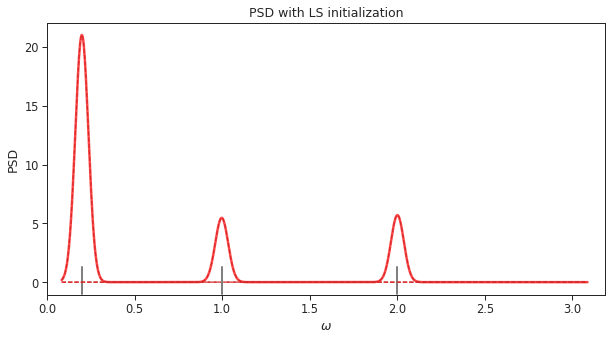

In [50]:
seed = np.random.randint(1, int(1e8))
np.random.seed(seed)

# initialize params
method = 'LS'
model.init_params(method=method)
# display(model.get_params())
print('Mixture means', get_param_across(model).reshape(-1))
print('Mixture scales', get_param_across(model, 'mixture_scales').reshape(-1))
print('Mixture weights', get_param_across(model, 'mixture_weights'))

plot_psd(model)
plt.title('PSD with {} initialization'.format(method));

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 150.086096
  Number of iterations: 20
  Number of functions evaluations: 31
Done in  0.011338194211324057  minutes
Mixture means [0.19913486 2.00218078 1.00315566]


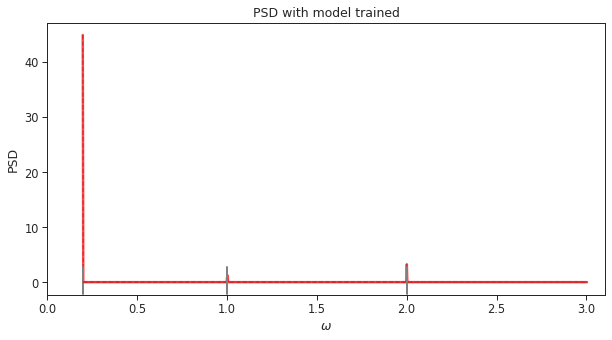

In [51]:
model.train(method='L-BFGS-B', maxiter=5000)
plot_psd(model)
plt.title('PSD with model trained')
print('Mixture means', get_param_across(model).reshape(-1))

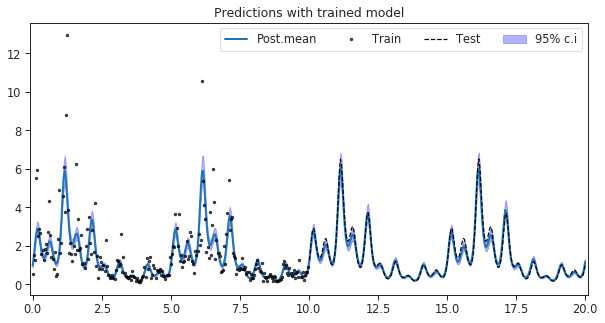

In [52]:
x_pred = [t.reshape(-1, 1)]
y_pred, lower_ci, upper_ci  = model.predict(x_pred)

plt.plot(x_pred[0], y_pred[0], label='Post.mean', lw=2, zorder=2)
plt.plot(t[:250], y_n[:250], '.k', alpha=0.7, zorder=2, label='Train')
plt.plot(t[250:], np.exp(y[250:]), '--k', zorder=3, label='Test')
plt.fill_between(x_pred[0].reshape(-1),
                 lower_ci[0],
                 upper_ci[0],
                 color='b',
                 alpha=0.3,
                 zorder=1,
                 label='95% c.i')
plt.xlim(-0.1, 20.1)
plt.legend(ncol=4)
plt.title('Predictions with trained model');

In [ ]:
# err_param, err_pred = experiment(t[:250], y_n[:250], t, y, target_freqs, Q=3, n_trials=10)

In [13]:
# err_param.mean(1), err_param.std(1)

In [14]:
# err_pred.mean(1), err_pred.std(1)


# Experiment 1: Mauna Loa

In [53]:
# dataset mauna loa
from sklearn.datasets import fetch_openml

def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

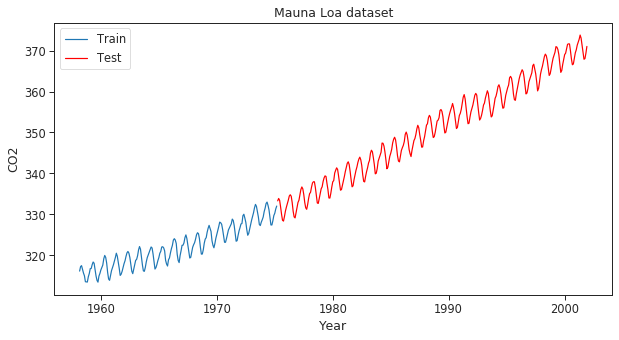

In [54]:
x, y = load_mauna_loa_atmospheric_co2()

stop = 200

plt.plot(x[:stop], y[:stop], label='Train')
plt.plot(x[stop:], y[stop:], 'r', label='Test')
plt.legend()
plt.xlabel('Year')
plt.ylabel('CO2');
plt.title('Mauna Loa dataset');

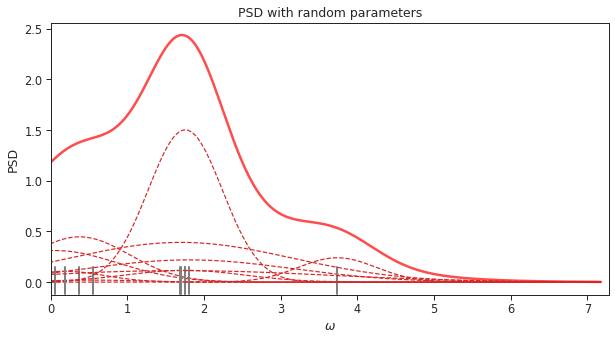

In [55]:
# add data
data = mogptk.Data(x[:stop, np.newaxis], y[:stop])
data.transform(mogptk.TransformDetrend)

# create model
model = mogptk.SM([data], Q=10)

plot_psd(model)
plt.title('PSD with random parameters');

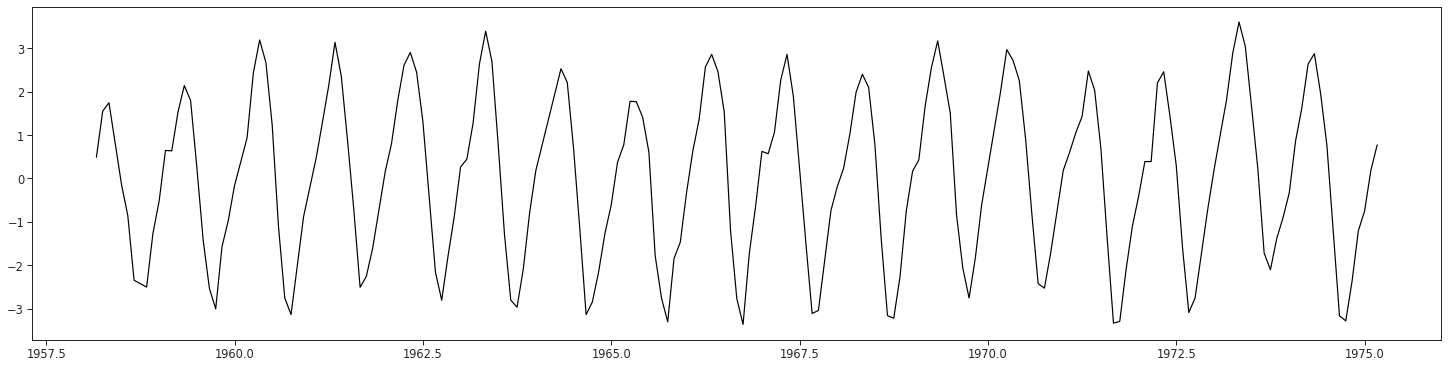

In [56]:
# plot detrended data
data.plot()

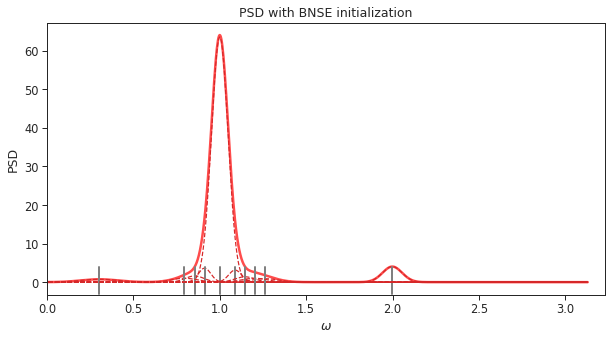

In [57]:
method = 'BNSE'
model.init_params(method)
plt.title('PSD with {} initialization'.format(method));
plot_psd(model)

INFO:tensorflow:Optimization terminated with:
  Message: Maximum number of iterations has been exceeded.
  Objective function value: 65.772202
  Number of iterations: 10000
  Number of functions evaluations: 20286
Done in  1.3034138003985087  minutes
CPU times: user 1min 23s, sys: 12.9 s, total: 1min 36s
Wall time: 1min 18s


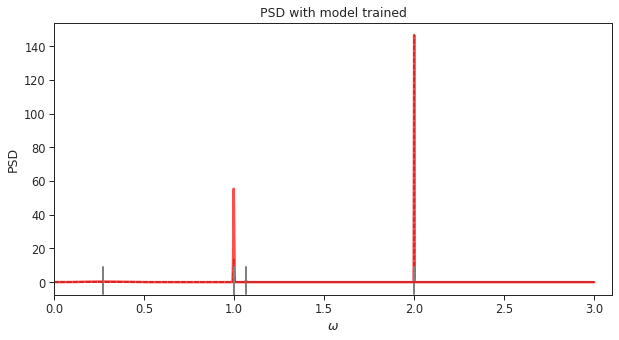

In [58]:
%%time 
model.train(method='L-BFGS-B', maxiter=10000, tol=1e-85)

plot_psd(model)
plt.title('PSD with model trained');

CPU times: user 216 ms, sys: 0 ns, total: 216 ms
Wall time: 213 ms


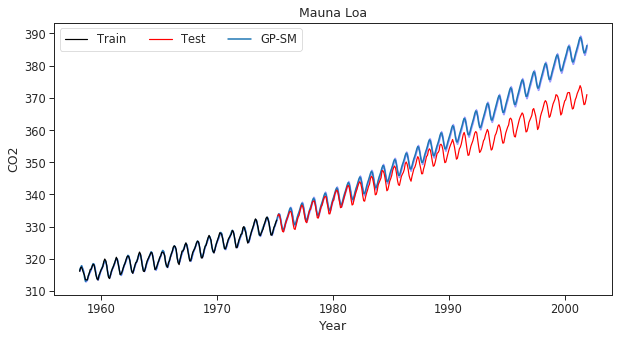

In [59]:
%%time 
# prediction
x_pred = [x.reshape(-1, 1)]

y_pred, lower_ci, upper_ci = model.predict(x_pred)

# plot
plt.plot(x[:stop], y[:stop], '-k', label='Train')
plt.plot(x[stop:], y[stop:], '-r', label='Test')
plt.plot(x_pred[0], y_pred[0], lw=1.5, zorder=1, label='GP-SM')
plt.fill_between(x_pred[0].reshape(-1),
                 lower_ci[0],
                 upper_ci[0],
                 color='b',
                 alpha=0.3,
                 zorder=1)
plt.legend(ncol=3)
plt.title('Mauna Loa')
plt.xlabel('Year')
plt.ylabel('CO2')

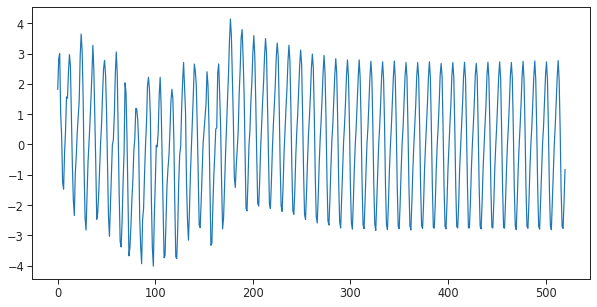

In [22]:
plt.plot(model.data[0].Y_mu_pred)

In [23]:
# true_means = np.zeros(model.Q)
# err_param, err_pred = experiment(x[:stop], y[:stop], x, y, true_means, Q=model.Q, n_trials=20)

In [24]:
# err_pred.mean(1), err_pred.std(1)

# Airplane passangers

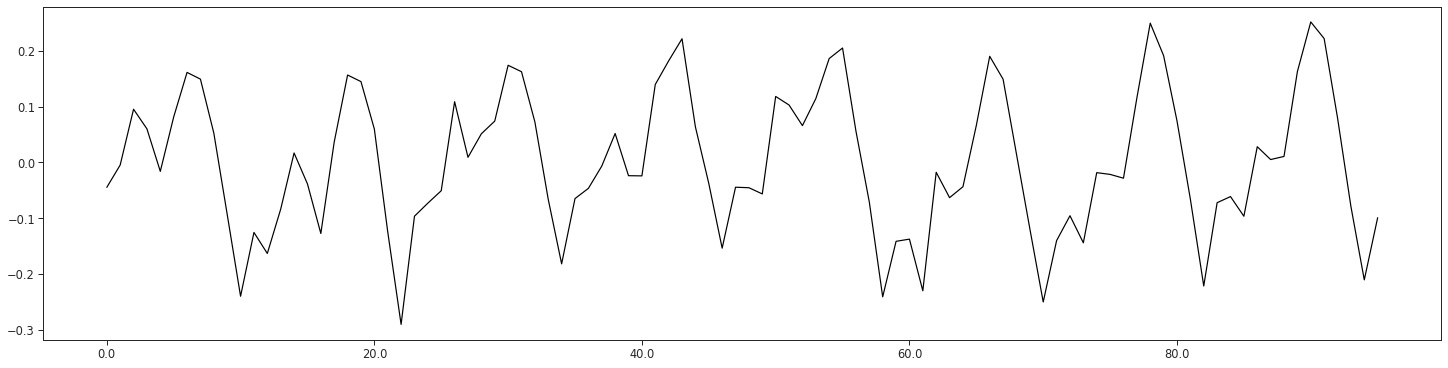

In [60]:
air = np.loadtxt('data/Airline_passenger.csv')

stop = 96

x = air[: ,0]
y = air[:, 1]

# add data
data = mogptk.Data(x[:stop, np.newaxis], y[:stop])

data.transform(mogptk.TransformLog)
data.transform(mogptk.TransformDetrend)

# create model
model = mogptk.SM([data], Q=5)

data.plot()

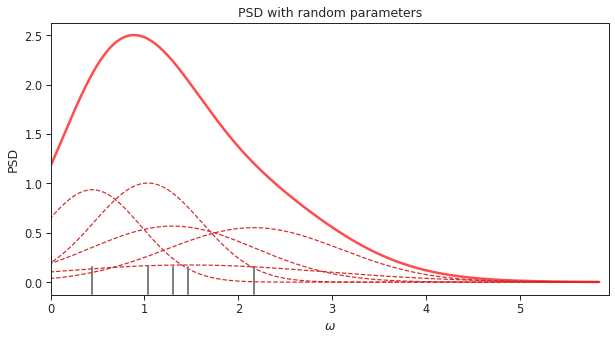

In [61]:
plot_psd(model)
plt.title('PSD with random parameters');

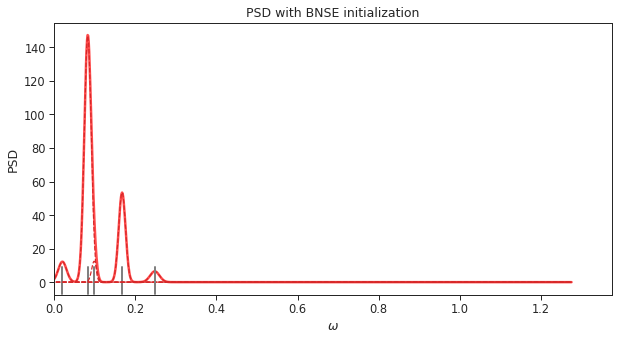

In [62]:
method = 'BNSE'
model.init_params(method)
plot_psd(model)
plt.title('PSD with {} initialization'.format(method));

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -102.360439
  Number of iterations: 204
  Number of functions evaluations: 294
Done in  0.018002823988596598  minutes


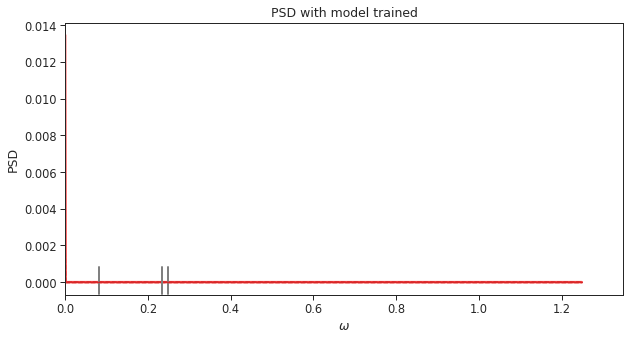

In [63]:
model.train('L-BFGS-B', maxiter=2000, tol=1e-80)
plot_psd(model)
plt.title('PSD with model trained');

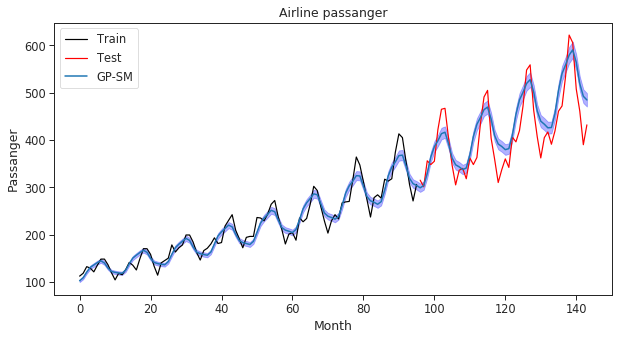

In [64]:
x_pred = [x[:, np.newaxis]]
y_pred, lower_ci, upper_ci = model.predict(x_pred)

# plot
plt.plot(x[:stop], y[:stop], '-k', label='Train')
plt.plot(x[stop:], y[stop:], '-r', label='Test')
plt.plot(x_pred[0], y_pred[0], lw=1.5, zorder=2, label='GP-SM')
plt.fill_between(x_pred[0].reshape(-1),
                 lower_ci[0],
                 upper_ci[0],
                 color='b',
                 alpha=0.3,
                 zorder=1)
plt.title('Airline passanger')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Passanger');

# Jura single output


Save for later (until multi input)